In [ ]:
!pip install torch

In [2]:
from google.colab import files
import zipfile
import os

In [3]:
with zipfile.ZipFile("dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")  # Extracts into "dataset/" directory


In [4]:
from sklearn.model_selection import train_test_split
import shutil

In [5]:
def split_dataset(src_dir, dest_root, train_ratio=0.7, val_ratio=0.15):
    os.makedirs(dest_root, exist_ok=True)
    for split in ['train', 'val', 'test']:
        for digit in range(10):
            os.makedirs(os.path.join(dest_root, split, str(digit)), exist_ok=True)

    for digit in os.listdir(src_dir):
        digit_path = os.path.join(src_dir, digit)
        if not os.path.isdir(digit_path): continue

        images = os.listdir(digit_path)
        train_imgs, temp_imgs = train_test_split(images, train_size=train_ratio, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        for img_name in train_imgs:
            shutil.copy(os.path.join(digit_path, img_name), os.path.join(dest_root, 'train', digit, img_name))
        for img_name in val_imgs:
            shutil.copy(os.path.join(digit_path, img_name), os.path.join(dest_root, 'val', digit, img_name))
        for img_name in test_imgs:
            shutil.copy(os.path.join(digit_path, img_name), os.path.join(dest_root, 'test', digit, img_name))



In [6]:
# Run this once
split_dataset("dataset/dataset", "dataset_split")

In [7]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((50, 50)),
    transforms.RandomRotation(15),
    transforms.RandomAffine(10, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((50, 50)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

data_dir = "dataset_split"

train_ds = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
val_ds   = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=test_transform)
test_ds  = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)


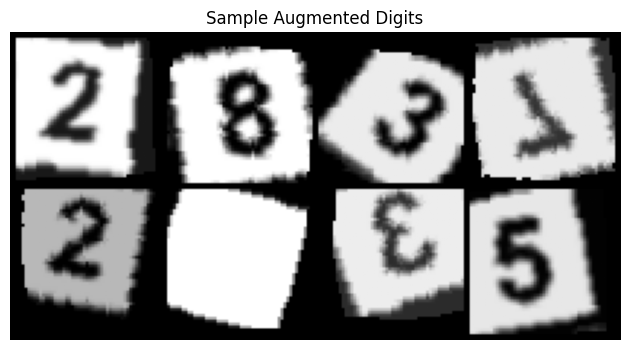

In [8]:
import matplotlib.pyplot as plt
import torchvision

images, labels = next(iter(train_loader))
grid = torchvision.utils.make_grid(images[:8], nrow=4, normalize=True)

plt.figure(figsize=(8, 4))
plt.imshow(grid.permute(1, 2, 0))  # Convert CHW to HWC
plt.axis('off')
plt.title("Sample Augmented Digits")
plt.show()


In [9]:
import torch.nn as nn

class SmallDigitCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(128*6*6, 256), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.net(x)


In [46]:
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SmallDigitCNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


def evaluate(model, dataloader, return_preds=False):
    model.eval()
    correct, total = 0, 0
    running_loss = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            preds = model(images)

            # Calculate loss
            loss = criterion(preds, labels)
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # Collect predictions if needed
            if return_preds:
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total

    if return_preds:
        # Calculate precision, recall, and F1-score
        #report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)], digits=4)
        #print(report)

        return avg_loss, accuracy, all_labels, all_preds
    else:
        return avg_loss, accuracy


def train(model, train_loader, val_loader, epochs=10):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct, total = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            preds = model(images)
            loss = criterion(preds, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update training metrics
            total_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        # Calculate average training loss and accuracy
        train_acc = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, val_loader)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_digit_model.pth")

    # Return the training history
    return train_losses, val_losses, train_accuracies, val_accuracies



In [17]:
# Training with History Collection
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, epochs=50)

# Load best model and test
model.load_state_dict(torch.load("best_digit_model.pth"))
test_acc = evaluate(model, test_loader)[1]
print(f"Test Accuracy: {test_acc:.4f}")


Epoch 1: 100%|██████████| 70/70 [00:02<00:00, 31.16it/s]


Epoch 1, Loss: 1.8963, Val Loss: 1.2235, Train Acc: 0.2946, Val Acc: 0.5646


Epoch 2: 100%|██████████| 70/70 [00:03<00:00, 22.74it/s]


Epoch 2, Loss: 1.1116, Val Loss: 0.7921, Train Acc: 0.5643, Val Acc: 0.6896


Epoch 3: 100%|██████████| 70/70 [00:01<00:00, 41.85it/s]


Epoch 3, Loss: 0.7619, Val Loss: 0.4877, Train Acc: 0.7067, Val Acc: 0.8250


Epoch 4: 100%|██████████| 70/70 [00:01<00:00, 42.02it/s]


Epoch 4, Loss: 0.5860, Val Loss: 0.3843, Train Acc: 0.7705, Val Acc: 0.8792


Epoch 5: 100%|██████████| 70/70 [00:01<00:00, 41.55it/s]


Epoch 5, Loss: 0.4160, Val Loss: 0.2310, Train Acc: 0.8496, Val Acc: 0.9375


Epoch 6: 100%|██████████| 70/70 [00:02<00:00, 34.73it/s]


Epoch 6, Loss: 0.3874, Val Loss: 0.3210, Train Acc: 0.8634, Val Acc: 0.8958


Epoch 7: 100%|██████████| 70/70 [00:01<00:00, 37.96it/s]


Epoch 7, Loss: 0.3321, Val Loss: 0.1739, Train Acc: 0.8844, Val Acc: 0.9583


Epoch 8: 100%|██████████| 70/70 [00:01<00:00, 41.33it/s]


Epoch 8, Loss: 0.2649, Val Loss: 0.1508, Train Acc: 0.9067, Val Acc: 0.9646


Epoch 9: 100%|██████████| 70/70 [00:01<00:00, 42.05it/s]


Epoch 9, Loss: 0.2620, Val Loss: 0.1526, Train Acc: 0.9076, Val Acc: 0.9604


Epoch 10: 100%|██████████| 70/70 [00:01<00:00, 41.14it/s]


Epoch 10, Loss: 0.2291, Val Loss: 0.1427, Train Acc: 0.9223, Val Acc: 0.9646


Epoch 11: 100%|██████████| 70/70 [00:01<00:00, 41.09it/s]


Epoch 11, Loss: 0.2035, Val Loss: 0.1152, Train Acc: 0.9313, Val Acc: 0.9708


Epoch 12: 100%|██████████| 70/70 [00:01<00:00, 35.70it/s]


Epoch 12, Loss: 0.1720, Val Loss: 0.1269, Train Acc: 0.9433, Val Acc: 0.9604


Epoch 13: 100%|██████████| 70/70 [00:01<00:00, 36.54it/s]


Epoch 13, Loss: 0.1620, Val Loss: 0.0916, Train Acc: 0.9437, Val Acc: 0.9792


Epoch 14: 100%|██████████| 70/70 [00:01<00:00, 41.45it/s]


Epoch 14, Loss: 0.1411, Val Loss: 0.0848, Train Acc: 0.9527, Val Acc: 0.9771


Epoch 15: 100%|██████████| 70/70 [00:01<00:00, 41.99it/s]


Epoch 15, Loss: 0.1578, Val Loss: 0.1120, Train Acc: 0.9482, Val Acc: 0.9708


Epoch 16: 100%|██████████| 70/70 [00:01<00:00, 41.92it/s]


Epoch 16, Loss: 0.1407, Val Loss: 0.0852, Train Acc: 0.9545, Val Acc: 0.9729


Epoch 17: 100%|██████████| 70/70 [00:01<00:00, 41.15it/s]


Epoch 17, Loss: 0.1250, Val Loss: 0.1085, Train Acc: 0.9558, Val Acc: 0.9667


Epoch 18: 100%|██████████| 70/70 [00:01<00:00, 37.20it/s]


Epoch 18, Loss: 0.1343, Val Loss: 0.0807, Train Acc: 0.9576, Val Acc: 0.9792


Epoch 19: 100%|██████████| 70/70 [00:02<00:00, 34.48it/s]


Epoch 19, Loss: 0.1259, Val Loss: 0.0718, Train Acc: 0.9540, Val Acc: 0.9812


Epoch 20: 100%|██████████| 70/70 [00:01<00:00, 41.03it/s]


Epoch 20, Loss: 0.1101, Val Loss: 0.0877, Train Acc: 0.9634, Val Acc: 0.9812


Epoch 21: 100%|██████████| 70/70 [00:01<00:00, 41.37it/s]


Epoch 21, Loss: 0.1216, Val Loss: 0.0748, Train Acc: 0.9603, Val Acc: 0.9750


Epoch 22: 100%|██████████| 70/70 [00:01<00:00, 40.84it/s]


Epoch 22, Loss: 0.1128, Val Loss: 0.0715, Train Acc: 0.9665, Val Acc: 0.9833


Epoch 23: 100%|██████████| 70/70 [00:01<00:00, 40.97it/s]


Epoch 23, Loss: 0.0924, Val Loss: 0.0786, Train Acc: 0.9701, Val Acc: 0.9792


Epoch 24: 100%|██████████| 70/70 [00:01<00:00, 36.54it/s]


Epoch 24, Loss: 0.1247, Val Loss: 0.0693, Train Acc: 0.9567, Val Acc: 0.9812


Epoch 25: 100%|██████████| 70/70 [00:02<00:00, 34.67it/s]


Epoch 25, Loss: 0.1211, Val Loss: 0.0813, Train Acc: 0.9621, Val Acc: 0.9771


Epoch 26: 100%|██████████| 70/70 [00:02<00:00, 29.08it/s]


Epoch 26, Loss: 0.0915, Val Loss: 0.0669, Train Acc: 0.9701, Val Acc: 0.9812


Epoch 27: 100%|██████████| 70/70 [00:02<00:00, 34.60it/s]


Epoch 27, Loss: 0.1022, Val Loss: 0.0711, Train Acc: 0.9665, Val Acc: 0.9771


Epoch 28: 100%|██████████| 70/70 [00:01<00:00, 41.60it/s]


Epoch 28, Loss: 0.0841, Val Loss: 0.0904, Train Acc: 0.9705, Val Acc: 0.9771


Epoch 29: 100%|██████████| 70/70 [00:01<00:00, 41.92it/s]


Epoch 29, Loss: 0.1034, Val Loss: 0.0922, Train Acc: 0.9647, Val Acc: 0.9688


Epoch 30: 100%|██████████| 70/70 [00:02<00:00, 32.52it/s]


Epoch 30, Loss: 0.0980, Val Loss: 0.0777, Train Acc: 0.9656, Val Acc: 0.9792


Epoch 31: 100%|██████████| 70/70 [00:01<00:00, 41.18it/s]


Epoch 31, Loss: 0.0798, Val Loss: 0.0846, Train Acc: 0.9705, Val Acc: 0.9750


Epoch 32: 100%|██████████| 70/70 [00:01<00:00, 41.48it/s]


Epoch 32, Loss: 0.1179, Val Loss: 0.0631, Train Acc: 0.9612, Val Acc: 0.9875


Epoch 33: 100%|██████████| 70/70 [00:01<00:00, 41.47it/s]


Epoch 33, Loss: 0.0697, Val Loss: 0.0646, Train Acc: 0.9732, Val Acc: 0.9854


Epoch 34: 100%|██████████| 70/70 [00:01<00:00, 41.89it/s]


Epoch 34, Loss: 0.0906, Val Loss: 0.0833, Train Acc: 0.9688, Val Acc: 0.9750


Epoch 35: 100%|██████████| 70/70 [00:01<00:00, 41.17it/s]


Epoch 35, Loss: 0.0818, Val Loss: 0.0678, Train Acc: 0.9679, Val Acc: 0.9833


Epoch 36: 100%|██████████| 70/70 [00:02<00:00, 34.29it/s]


Epoch 36, Loss: 0.0909, Val Loss: 0.0628, Train Acc: 0.9714, Val Acc: 0.9771


Epoch 37: 100%|██████████| 70/70 [00:01<00:00, 39.26it/s]


Epoch 37, Loss: 0.0969, Val Loss: 0.0851, Train Acc: 0.9710, Val Acc: 0.9750


Epoch 38: 100%|██████████| 70/70 [00:01<00:00, 40.71it/s]


Epoch 38, Loss: 0.0751, Val Loss: 0.0740, Train Acc: 0.9746, Val Acc: 0.9812


Epoch 39: 100%|██████████| 70/70 [00:01<00:00, 41.65it/s]


Epoch 39, Loss: 0.0818, Val Loss: 0.0645, Train Acc: 0.9719, Val Acc: 0.9833


Epoch 40: 100%|██████████| 70/70 [00:01<00:00, 41.52it/s]


Epoch 40, Loss: 0.0804, Val Loss: 0.0685, Train Acc: 0.9705, Val Acc: 0.9833


Epoch 41: 100%|██████████| 70/70 [00:01<00:00, 41.29it/s]


Epoch 41, Loss: 0.0803, Val Loss: 0.0714, Train Acc: 0.9728, Val Acc: 0.9833


Epoch 42: 100%|██████████| 70/70 [00:02<00:00, 34.70it/s]


Epoch 42, Loss: 0.0829, Val Loss: 0.0626, Train Acc: 0.9701, Val Acc: 0.9854


Epoch 43: 100%|██████████| 70/70 [00:01<00:00, 37.67it/s]


Epoch 43, Loss: 0.0759, Val Loss: 0.0747, Train Acc: 0.9710, Val Acc: 0.9812


Epoch 44: 100%|██████████| 70/70 [00:01<00:00, 41.19it/s]


Epoch 44, Loss: 0.0920, Val Loss: 0.0530, Train Acc: 0.9665, Val Acc: 0.9812


Epoch 45: 100%|██████████| 70/70 [00:01<00:00, 42.04it/s]


Epoch 45, Loss: 0.0702, Val Loss: 0.0734, Train Acc: 0.9732, Val Acc: 0.9750


Epoch 46: 100%|██████████| 70/70 [00:01<00:00, 41.91it/s]


Epoch 46, Loss: 0.0637, Val Loss: 0.0668, Train Acc: 0.9781, Val Acc: 0.9875


Epoch 47: 100%|██████████| 70/70 [00:01<00:00, 41.98it/s]


Epoch 47, Loss: 0.0842, Val Loss: 0.0795, Train Acc: 0.9683, Val Acc: 0.9875


Epoch 48: 100%|██████████| 70/70 [00:01<00:00, 37.18it/s]


Epoch 48, Loss: 0.0772, Val Loss: 0.0706, Train Acc: 0.9737, Val Acc: 0.9854


Epoch 49: 100%|██████████| 70/70 [00:01<00:00, 35.12it/s]


Epoch 49, Loss: 0.0782, Val Loss: 0.0664, Train Acc: 0.9696, Val Acc: 0.9812


Epoch 50: 100%|██████████| 70/70 [00:01<00:00, 41.45it/s]


Epoch 50, Loss: 0.0769, Val Loss: 0.0841, Train Acc: 0.9737, Val Acc: 0.9667


<ipython-input-17-bd451709673a>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_digit_model.pth"))


Test Accuracy: 0.9730


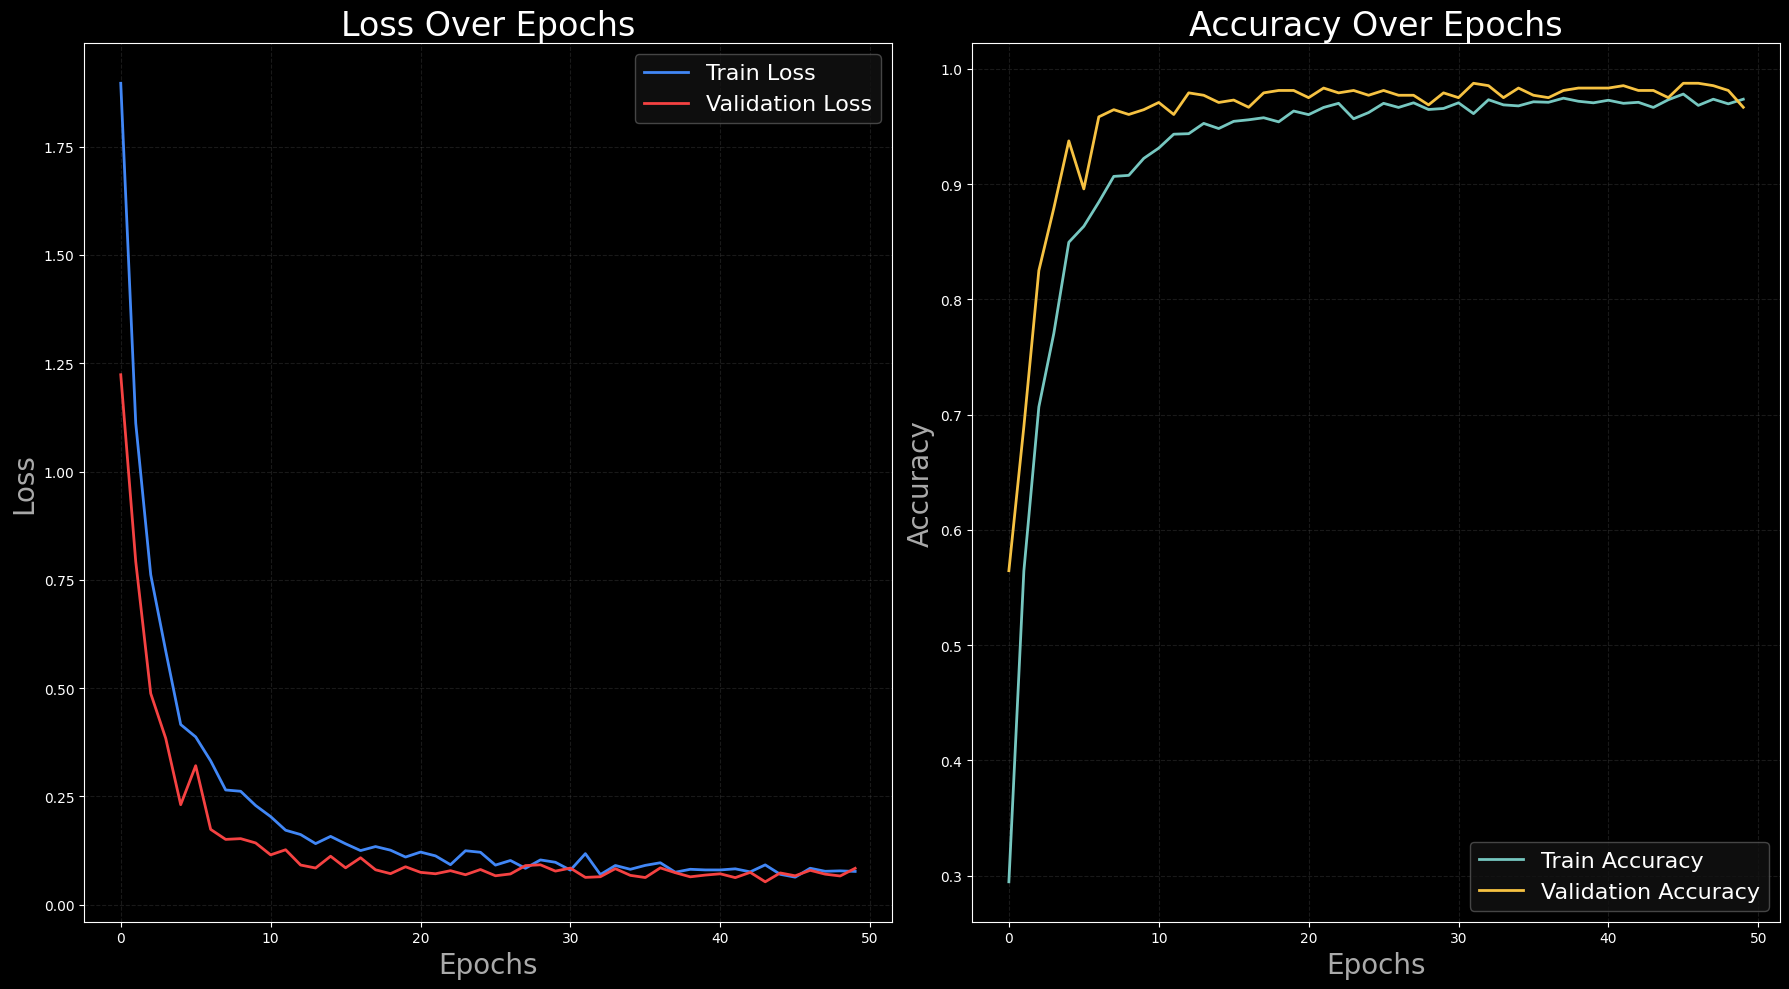

<Figure size 640x480 with 0 Axes>

In [52]:
# Visualization Section for Colab - DARK MODE
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.figure(figsize=(18, 10))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss", color="#4187f6", linewidth=2)
plt.plot(val_losses, label="Validation Loss", color="#f54242", linewidth=2)
plt.title("Loss Over Epochs", fontsize=24, color="#ffffff")
plt.xlabel("Epochs", fontsize=20, color="#aaaaaa")
plt.ylabel("Loss", fontsize=20, color="#aaaaaa")
plt.legend(facecolor="#121212", edgecolor="#555555", fontsize=16)
plt.grid(color="#555555", linestyle="--", alpha=0.3)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Accuracy", color="#76c7c0", linewidth=2)
plt.plot(val_accuracies, label="Validation Accuracy", color="#f6c242", linewidth=2)
plt.title("Accuracy Over Epochs", fontsize=24, color="#ffffff")
plt.xlabel("Epochs", fontsize=20, color="#aaaaaa")
plt.ylabel("Accuracy", fontsize=20, color="#aaaaaa")
plt.legend(facecolor="#121212", edgecolor="#555555", fontsize=16)
plt.grid(color="#555555", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

# save the plot
plt.savefig("train_loss_darkk.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())




In [20]:
torch.save(model.state_dict(), "digit_model_weights_new.pth")


In [21]:
torch.save(model, "digit_model_full_matan_new.pth")


In [47]:
# Load the best model for evaluation
model.load_state_dict(torch.load("digit_model_weights_new.pth"))

# Get predictions and true labels
test_loss, test_acc, all_labels, all_preds = evaluate(model, test_loader, return_preds=True)

print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


<ipython-input-47-91c6389698dd>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("digit_model_weights_new.pth"))


Test Accuracy: 0.9730, Test Loss: 0.0959


In [49]:

report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(10)], digits=4)
print(report)


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        48
           1     0.9796    1.0000    0.9897        48
           2     0.9796    1.0000    0.9897        48
           3     0.9796    1.0000    0.9897        48
           4     1.0000    1.0000    1.0000        48
           5     1.0000    0.9583    0.9787        48
           6     0.8824    0.9184    0.9000        49
           7     1.0000    0.9792    0.9895        48
           8     1.0000    1.0000    1.0000        48
           9     0.9130    0.8750    0.8936        48

    accuracy                         0.9730       481
   macro avg     0.9734    0.9731    0.9731       481
weighted avg     0.9732    0.9730    0.9729       481



In [50]:
with open("classification_report.txt", "w") as f:
    f.write(report)

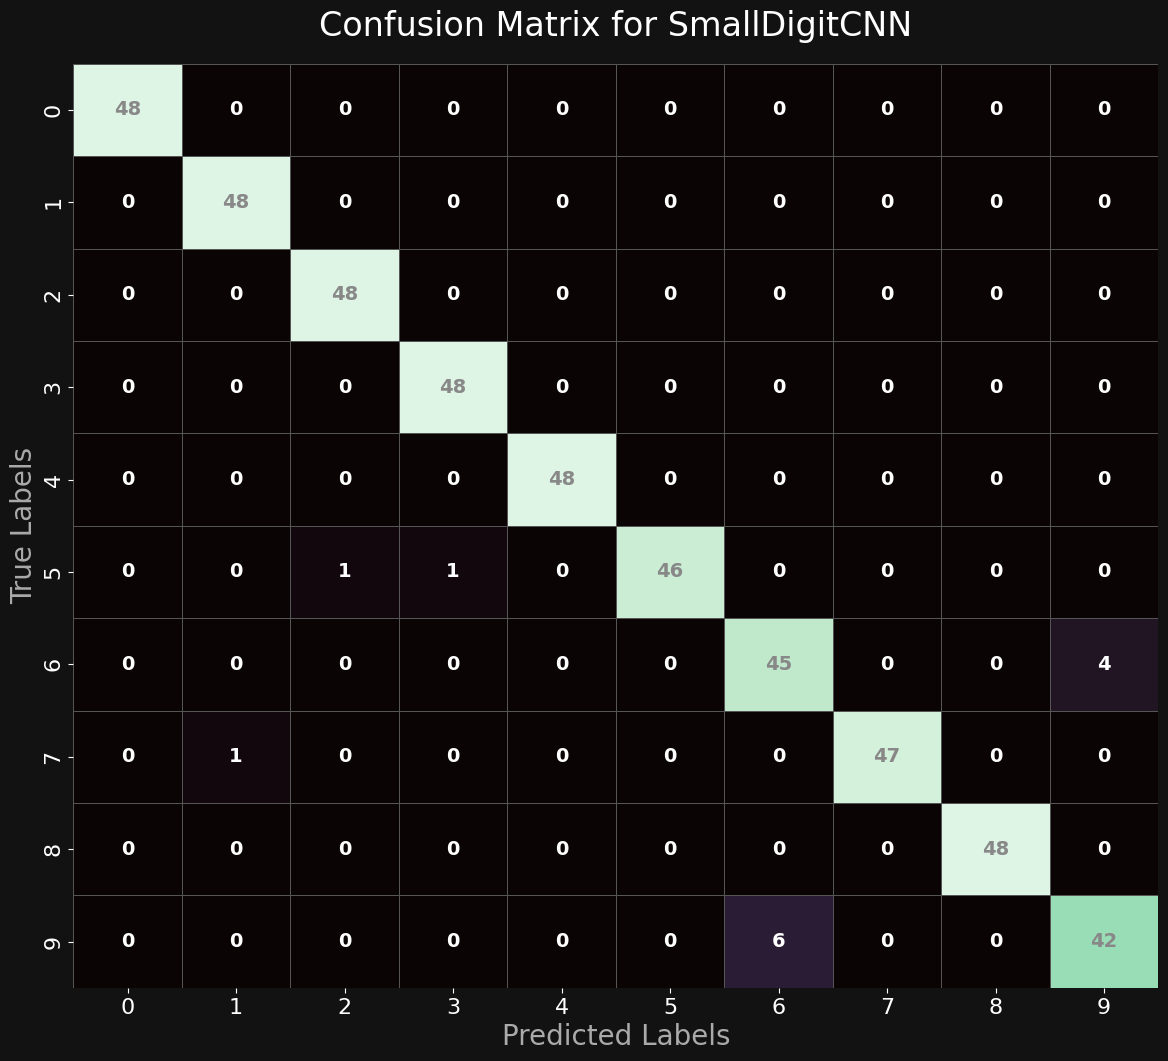

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Dark mode settings
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#121212')

# Draw the heatmap
sns.heatmap(
    cm,
    annot=False,
    fmt="d",
    cmap="mako",
    cbar=False,
    linewidths=0.5,
    linecolor="#555555",
    ax=ax
)

# Add custom diagonal text color
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        value = cm[i, j]
        if i == j:
            # Darker color for diagonal
            text_color = "#888888"
        else:
            # Brighter color for off-diagonal
            text_color = "#ffffff"
        ax.text(j + 0.5, i + 0.5, value, ha="center", va="center", fontsize=14, fontweight="bold", color=text_color)

# Customize axis labels and title
ax.set_xlabel("Predicted Labels", fontsize=20, color="#aaaaaa")
ax.set_ylabel("True Labels", fontsize=20, color="#aaaaaa")
ax.set_title("Confusion Matrix for SmallDigitCNN", fontsize=24, color="#ffffff", pad=20)

# Customize ticks
plt.xticks(fontsize=16, color="#ffffff")
plt.yticks(fontsize=16, color="#ffffff")

# Save the figure
plt.savefig("confusion_matrix_custom_diagonal.png", dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())

plt.show()
